# TensorFlow Keras Comparsion 

See the accompanying blog post on my [home page](http://georgep.xyz).


In [1]:
%pylab inline
import seaborn as sns

# How we'll get batches 
def get_batch(array_size, n_samples=100):
    x = np.random.rand(n_samples, array_size)
    y = x.argsort()
    return x, y

# Our easily interpretable evaluation function
def evaluate(y_pred, y_actual):
    score = np.mean(y_pred.round() == y_actual)*100
    return score

Populating the interactive namespace from numpy and matplotlib


Before we get any further, lets also define some hyperparameters we'll use in all the tests.

In [2]:
array_size = 2 # How long the arrays are we'll sort. Not very long at all.
runs = 500 # Number of training runs
batch_size = 10000 # Number of training examples in each training run

# 1 layer net in pure TensorFlow

In [3]:
import tensorflow as tf

# Tensorflow seperates the 'graph' itself from the 'session' you run it in.
# Basically, you create the graph, then initalize and run all the variables 
# for that graph in a 'session'. The interactive session below means you 
# can worry about this less.
sess = tf.InteractiveSession()

#### Build the model

# First, we need to create placeholder variables for the inputs and outputs
x = tf.placeholder(tf.float32, shape=[None, array_size])
y_ = tf.placeholder(tf.float32, shape=[None, array_size])

# Now we need to set up the variables we'll use for our 'fully connected' layer
W = tf.Variable(tf.zeros([array_size, array_size]))
b = tf.Variable(tf.zeros([array_size]))

# Tell TF what the operation is here - basically that it's a fully connected layer
y = tf.matmul(x,W) + b

# Define the loss function. I wanted mean square error, but it's not available built in, so you 
# need to compute it manually
error = tf.reduce_mean(tf.square(tf.sub(y_, y)))

# Define the optimizer we'll use 
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(error)

# Initialize all the variables 
sess.run(tf.global_variables_initializer())

#### Train the model
losses_tf = []
for i in range(runs):
    x_train, y_train = get_batch(array_size, batch_size)
    _, loss_val = sess.run([train_step, error],
                           feed_dict={x: x_train, y_:y_train})
    losses_tf.append(loss_val)

# Test 
x_test, y_test = get_batch(array_size, batch_size)
_, pred, loss_val = sess.run([train_step, y, error],
                       feed_dict={x: x_test, y_: y_test})

test_score = evaluate(pred, y_test)

print(test_score)

99.65


# 1 layer net (effectively linear regression) in Keras

In [10]:
import keras

# Initiate our model
model = keras.models.Sequential()

# Add the layers
layer = keras.layers.Dense(output_dim=array_size, input_dim=array_size)
model.add(layer)

# 'Compile' the model, and define the loss function,
sgd = keras.optimizers.SGD(lr=0.5)
model.compile(loss='mse', optimizer=sgd)

losses_keras = []
for i in range(runs):
    x_train, y_train = get_batch(array_size, batch_size)
    loss = model.train_on_batch(x_train, y_train)
    losses_keras.append(loss)
x_test, y_test = get_batch(array_size, batch_size)
y_pred = model.predict(x_test)
score = evaluate(y_pred, y_test)

print('score: ', score)

score:  99.94


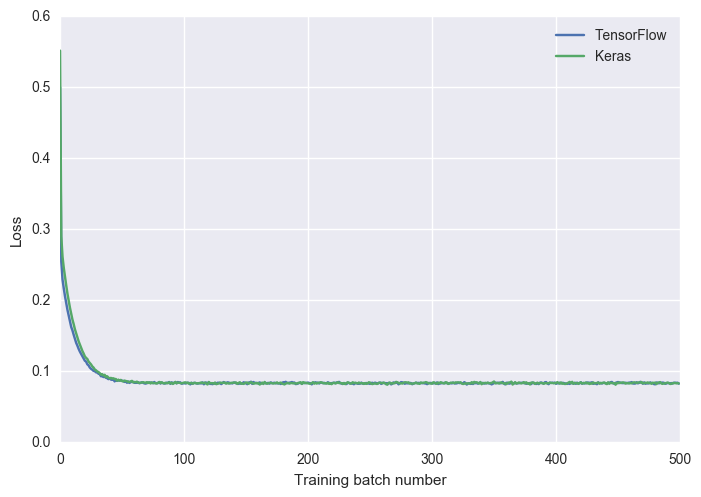

In [11]:
plt.plot(losses_tf)
plt.plot(losses_keras)
plt.legend(['TensorFlow', 'Keras'])
plt.xlabel('Training batch number')
plt.ylabel('Loss')

# Get some speed benchmarks

In [6]:
def train_tf():
    # Tensorflow seperates the 'graph' itself from the 'session' you run it in.
    # Basically, you create the graph, then initalize and run all the variables 
    # for that graph in a 'session'. The interactive session below means you 
    # can worry about this less.
    sess = tf.InteractiveSession()

    #### Build the model

    # First, we need to create placeholder variables for the inputs and outputs
    x = tf.placeholder(tf.float32, shape=[None, array_size])
    y_ = tf.placeholder(tf.float32, shape=[None, array_size])

    # Now we need to set up the variables we'll use for our 'fully connected' layer
    W = tf.Variable(tf.zeros([array_size, array_size]))
    b = tf.Variable(tf.zeros([array_size]))

    # Tell TF what the operation is here - basically that it's a fully connected layer
    y = tf.matmul(x,W) + b

    # Define the loss function. I wanted mean square error, but it's not available built in, so you 
    # need to compute it manually
    error = tf.reduce_mean(tf.square(tf.sub(y_, y)))

    # Define the optimizer we'll use 
    train_step = tf.train.GradientDescentOptimizer(0.5).minimize(error)

    # Initialize all the variables 
    sess.run(tf.global_variables_initializer())

    #### Train the model
    losses_tf = []
    for i in range(runs):
        x_train, y_train = get_batch(array_size, batch_size)
        _, loss_val = sess.run([train_step, error],
                               feed_dict={x: x_train, y_:y_train})
        losses_tf.append(loss_val)


def train_keras():
    # Initiate our model
    model = keras.models.Sequential()

    # Add the layers
    layer = keras.layers.Dense(output_dim=array_size, input_dim=array_size)
    model.add(layer)

    # 'Compile' the model, and define the loss function,
    sgd = keras.optimizers.SGD(lr=0.5)
    model.compile(loss='mse', optimizer=sgd)

    losses_keras = []
    for i in range(runs):
        x_train, y_train = get_batch(array_size, batch_size)
        loss = model.train_on_batch(x_train, y_train)
        losses_keras.append(loss)
        
%timeit train_tf()
%timeit train_keras()

1 loop, best of 3: 1.25 s per loop
1 loop, best of 3: 1.53 s per loop
